# Connect4 AI Game Memory and Time Comparison
### PS: The study of winning rates revealed misleading results, so the focus was more on speed and memory.


#### Game Implementation

In [13]:
import numpy as np
import random
import matplotlib.pyplot as plt

class Connect4:
    ROWS = 6
    COLS = 7

    def __init__(self):
        self.board = np.zeros((self.ROWS, self.COLS), dtype=int)  # 0 for empty, 1 for Player 1, 2 for Player 2
        self.current_player = 1  # Player 1 starts

    def drop_piece(self, col):
        for row in range(self.ROWS-1, -1, -1):
            if self.board[row, col] == 0:
                self.board[row, col] = self.current_player
                break

    def switch_player(self):
        self.current_player = 1 if self.current_player == 2 else 2

    def is_valid_move(self, col):
        return self.board[0, col] == 0  # Check if top row is empty

    def is_over(self):
        return self.check_winner() or np.all(self.board != 0)  # Game over if winner or board is full

    def check_winner(self):
        # Simple win condition check (horizontal, vertical, and diagonal)
        # Can be optimized for efficiency.
        for row in range(self.ROWS):
            for col in range(self.COLS-3):
                if self.board[row, col] == self.current_player and \
                   self.board[row, col] == self.board[row, col+1] == self.board[row, col+2] == self.board[row, col+3]:
                    return True

        for row in range(self.ROWS-3):
            for col in range(self.COLS):
                if self.board[row, col] == self.current_player and \
                   self.board[row, col] == self.board[row+1, col] == self.board[row+2, col] == self.board[row+3, col]:
                    return True

        for row in range(self.ROWS-3):
            for col in range(self.COLS-3):
                if self.board[row, col] == self.current_player and \
                   self.board[row, col] == self.board[row+1, col+1] == self.board[row+2, col+2] == self.board[row+3, col+3]:
                    return True

        for row in range(3, self.ROWS):
            for col in range(self.COLS-3):
                if self.board[row, col] == self.current_player and \
                   self.board[row, col] == self.board[row-1, col+1] == self.board[row-2, col+2] == self.board[row-3, col+3]:
                    return True
        return False

    def apply_move(self, col):
        if self.is_valid_move(col):
            self.drop_piece(col)
            if not self.is_over():
                self.switch_player()

    def get_result(self):
        if self.check_winner():
            return f"Player {self.current_player} wins!"
        return "Draw"


In [2]:
import time
import tracemalloc

def play_game(algorithm1, algorithm2, game_class):
    game = game_class()  # Initialize a new game
    current_algorithm = algorithm1  # Start with the first algorithm

    while not game.is_over():
        start_time = time.time()
        
        # Get the current algorithm's move
        move = current_algorithm.make_move(game)
        
        # If move is invalid, end the game
        if move is None:
            print(f"{current_algorithm.name} has no valid moves. Game over.")
            break
        
        # Log time taken for move
        move_time = time.time() - start_time
        print(f"{current_algorithm.name} took {move_time:.4f} seconds for this move.")
        
        # Apply move to the game
        game.apply_move(move)
        
        # Switch algorithms
        current_algorithm = algorithm2 if current_algorithm == algorithm1 else algorithm1

    # Determine the result of the game
    if game.check_winner():
        winner = algorithm1.name if game.current_player == algorithm1 else algorithm2.name
        return winner
    else:
        return "Draw"

In [3]:
def benchmark_algorithm(algorithm1, algorithm2, games, game_class):
    times = []
    memory_usage = []
    results = {algorithm1.name: 0, algorithm2.name: 0, "Draw": 0}

    for i in range(games):
        tracemalloc.start()  # Start memory tracking

        start_time = time.time()
        result = play_game(algorithm1, algorithm2, game_class)
        end_time = time.time()

        # Track execution time and memory
        exec_time = end_time - start_time
        current, peak = tracemalloc.get_traced_memory()
        
        # Log results
        times.append(exec_time)
        memory_usage.append(peak)
        results[result] += 1
        
        tracemalloc.stop()

#### Minimax vs BFS

In [4]:
import pandas as pd
from collections import deque

class MinimaxAlgorithm:
    def __init__(self, depth=4):
        self.name = "Minimax"
        self.depth = depth
    
    def make_move(self, game):
        best_score = float('-inf')
        best_move = None
        
        for col in range(game.COLS):
            if game.is_valid_move(col):
                # Make copy of game state
                temp_game = Connect4()
                temp_game.board = np.copy(game.board)
                temp_game.current_player = game.current_player
                
                temp_game.apply_move(col)
                score = self.minimax(temp_game, self.depth - 1, False)
                
                if score > best_score:
                    best_score = score
                    best_move = col
        
        return best_move
    
    def minimax(self, game, depth, maximizing):
        if depth == 0 or game.is_over():
            return self.evaluate_board(game)
        
        if maximizing:
            max_eval = float('-inf')
            for col in range(game.COLS):
                if game.is_valid_move(col):
                    temp_game = Connect4()
                    temp_game.board = np.copy(game.board)
                    temp_game.current_player = game.current_player
                    temp_game.apply_move(col)
                    eval = self.minimax(temp_game, depth - 1, False)
                    max_eval = max(max_eval, eval)
            return max_eval
        else:
            min_eval = float('inf')
            for col in range(game.COLS):
                if game.is_valid_move(col):
                    temp_game = Connect4()
                    temp_game.board = np.copy(game.board)
                    temp_game.current_player = game.current_player
                    temp_game.apply_move(col)
                    eval = self.minimax(temp_game, depth - 1, True)
                    min_eval = min(min_eval, eval)
            return min_eval
    
    def evaluate_board(self, game):
        if game.check_winner():
            return 100 if game.current_player == 1 else -100
        return 0

class BFSAlgorithm:
    def __init__(self):
        self.name = "BFS"
    
    def make_move(self, game):
        queue = deque([(np.copy(game.board), None)])
        visited = set()
        
        while queue:
            current_board, first_move = queue.popleft()
            board_hash = hash(current_board.tobytes())
            
            if board_hash in visited:
                continue
                
            visited.add(board_hash)
            
            # Try each possible move
            for col in range(game.COLS):
                if game.is_valid_move(col):
                    temp_game = Connect4()
                    temp_game.board = np.copy(current_board)
                    temp_game.current_player = game.current_player
                    temp_game.apply_move(col)
                    
                    # If this is the first move in sequence, store it
                    next_move = first_move if first_move is not None else col
                    
                    # If this move wins, return it
                    if temp_game.check_winner():
                        return next_move
                        
                    queue.append((temp_game.board, next_move))
        
        # If no winning move found, choose first available column
        for col in range(game.COLS):
            if game.is_valid_move(col):
                return col
        return None

def run_benchmarks(n_games=100):
    minimax = MinimaxAlgorithm()
    bfs = BFSAlgorithm()
    
    all_times = []
    all_memory = []
    
    for i in range(n_games):
        tracemalloc.start()
        start_time = time.time()
        
        # Play a single game
        game = Connect4()
        current_algorithm = minimax
        
        while not game.is_over():
            move = current_algorithm.make_move(game)
            if move is None:
                break
            
            game.apply_move(move)
            current_algorithm = bfs if current_algorithm == minimax else minimax
        
        # Record metrics
        end_time = time.time()
        current, peak = tracemalloc.get_traced_memory()
        
        all_times.append(end_time - start_time)
        all_memory.append(peak / 1024 / 1024)  # Convert to MB
        
        tracemalloc.stop()
    
    # Create DataFrame with results
    df = pd.DataFrame({
        'Algorithm': ['Minimax vs BFS'],
        'Average Time (s)': [np.mean(all_times)],
        'Average Memory (MB)': [np.mean(all_memory)]
    })
    
    return df

# Run the benchmarks and display results
# It was planned to play 100 times but it takes too much time.
# Thus, decreased the times he plays.
results_df = run_benchmarks(10)
print("\nBenchmark Results:")
print(results_df)


Benchmark Results:
        Algorithm  Average Time (s)  Average Memory (MB)
0  Minimax vs BFS          5.746048             0.108546


 #### Minimax vs DFS 

In [5]:
class DFSAlgorithm:
    def __init__(self):
        self.name = "DFS"
        self.max_depth = 6  # Limit search depth to prevent too deep recursion
    
    def make_move(self, game):
        best_move = None
        visited = set()
        
        def dfs(current_board, depth):
            if depth >= self.max_depth:
                return None
                
            board_hash = hash(current_board.tobytes())
            if board_hash in visited:
                return None
                
            visited.add(board_hash)
            
            # Try each possible move
            for col in range(game.COLS):
                if game.is_valid_move(col):
                    temp_game = Connect4()
                    temp_game.board = np.copy(current_board)
                    temp_game.current_player = game.current_player
                    temp_game.apply_move(col)
                    
                    # If this move wins, return it
                    if temp_game.check_winner():
                        return col
                    
                    # Recursively search deeper
                    result = dfs(temp_game.board, depth + 1)
                    if result is not None:
                        return col
            
            return None
        
        # Try to find winning move
        best_move = dfs(game.board, 0)
        
        # If no winning move found, choose first available column
        if best_move is None:
            for col in range(game.COLS):
                if game.is_valid_move(col):
                    return col
        
        return best_move

def run_minimax_dfs_benchmark(n_games=100):
    minimax = MinimaxAlgorithm()
    dfs = DFSAlgorithm()
    
    all_times = []
    all_memory = []
    
    for i in range(n_games):
        tracemalloc.start()
        start_time = time.time()
        
        # Play a single game
        game = Connect4()
        current_algorithm = minimax
        
        while not game.is_over():
            move = current_algorithm.make_move(game)
            if move is None:
                break
            
            game.apply_move(move)
            current_algorithm = dfs if current_algorithm == minimax else minimax
        
        # Record metrics
        end_time = time.time()
        current, peak = tracemalloc.get_traced_memory()
        
        all_times.append(end_time - start_time)
        all_memory.append(peak / 1024 / 1024)  # Convert to MB
        
        tracemalloc.stop()
    
    # Create new row for results
    new_row = pd.DataFrame({
        'Algorithm': ['Minimax vs DFS'],
        'Average Time (s)': [np.mean(all_times)],
        'Average Memory (MB)': [np.mean(all_memory)]
    })
    
    # Append new results to existing DataFrame
    global results_df
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    return results_df

# Run the benchmark and update results
# Run the benchmark and update results
results_df = run_minimax_dfs_benchmark(10)
print("\nBenchmark Results:")
print(results_df)


Benchmark Results:
        Algorithm  Average Time (s)  Average Memory (MB)
0  Minimax vs BFS          5.746048             0.108546
1  Minimax vs DFS          6.374441             0.014959


#### Minimax vs Random

In [6]:
class RandomAlgorithm:
    def __init__(self):
        self.name = "Random"
    
    def make_move(self, game):
        # Get all valid moves
        valid_moves = [col for col in range(game.COLS) if game.is_valid_move(col)]
        
        # If there are valid moves, choose one randomly
        if valid_moves:
            return random.choice(valid_moves)
        return None

def run_minimax_random_benchmark(n_games=100):
    minimax = MinimaxAlgorithm()
    random_algo = RandomAlgorithm()
    
    all_times = []
    all_memory = []
    wins = {"Minimax": 0, "Random": 0, "Draw": 0}
    
    for i in range(n_games):
        tracemalloc.start()
        start_time = time.time()
        
        # Play a single game
        game = Connect4()
        current_algorithm = minimax
        
        while not game.is_over():
            move = current_algorithm.make_move(game)
            if move is None:
                break
            
            # Store the current player before making the move
            current_player = game.current_player
            
            game.apply_move(move)
            
            # Check if the game is over after this move
            if game.check_winner():
                if current_player == 1:  # Minimax is player 1
                    wins["Minimax"] += 1
                else:
                    wins["Random"] += 1
            elif game.is_over():  # If game is over but no winner, it's a draw
                wins["Draw"] += 1
                
            current_algorithm = random_algo if current_algorithm == minimax else minimax
        
        # Record metrics
        end_time = time.time()
        current, peak = tracemalloc.get_traced_memory()
        
        all_times.append(end_time - start_time)
        all_memory.append(peak / 1024 / 1024)  # Convert to MB
        
        tracemalloc.stop()
    
    # Create new row for results
    new_row = pd.DataFrame({
        'Algorithm': ['Minimax vs Random'],
        'Average Time (s)': [np.mean(all_times)],
        'Average Memory (MB)': [np.mean(all_memory)]
    })
    
    # Append new results to existing DataFrame
    global results_df
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    return results_df

# Run the benchmark and update results
results_df = run_minimax_random_benchmark(10)
print("\nUpdated Benchmark Results:")
print(results_df)


Updated Benchmark Results:
           Algorithm  Average Time (s)  Average Memory (MB)
0     Minimax vs BFS          5.746048             0.108546
1     Minimax vs DFS          6.374441             0.014959
2  Minimax vs Random          5.980513             0.017395


#### DFS vs BFS

In [7]:
def run_dfs_bfs_benchmark(n_games=100):
    dfs = DFSAlgorithm()
    bfs = BFSAlgorithm()
    
    all_times = []
    all_memory = []
    wins = {"DFS": 0, "BFS": 0, "Draw": 0}
    total_moves = []
    
    for i in range(n_games):
        tracemalloc.start()
        start_time = time.time()
        
        # Play a single game
        game = Connect4()
        current_algorithm = dfs
        moves_count = 0
        
        while not game.is_over():
            move = current_algorithm.make_move(game)
            if move is None:
                break
            
            moves_count += 1
            # Store the current player before making the move
            current_player = game.current_player
            
            game.apply_move(move)
            
            # Check if the game is over after this move
            if game.check_winner():
                if current_player == 1:  # DFS is player 1
                    wins["DFS"] += 1
                else:
                    wins["BFS"] += 1
            elif game.is_over():  # If game is over but no winner, it's a draw
                wins["Draw"] += 1
                
            current_algorithm = bfs if current_algorithm == dfs else dfs
        
        total_moves.append(moves_count)
        
        # Record metrics
        end_time = time.time()
        current, peak = tracemalloc.get_traced_memory()
        
        all_times.append(end_time - start_time)
        all_memory.append(peak / 1024 / 1024)  # Convert to MB
        
        tracemalloc.stop()
    
    # Create new row for results
    new_row = pd.DataFrame({
        'Algorithm': ['DFS vs BFS'],
        'Average Time (s)': [np.mean(all_times)],
        'Average Memory (MB)': [np.mean(all_memory)]
    })
    
    # Append new results to existing DataFrame
    global results_df
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    return results_df

# Run the benchmark and update results
results_df = run_dfs_bfs_benchmark(10)
print("\nUpdated Benchmark Results:")
print(results_df)


Updated Benchmark Results:
           Algorithm  Average Time (s)  Average Memory (MB)
0     Minimax vs BFS          5.746048             0.108546
1     Minimax vs DFS          6.374441             0.014959
2  Minimax vs Random          5.980513             0.017395
3         DFS vs BFS          0.334319             0.122681


#### Minimax vs Monte Carlo Tree Search

In [8]:
import math
from copy import deepcopy

class MCTSNode:
    def __init__(self, game_state, parent=None, move=None):
        self.game_state = game_state
        self.parent = parent
        self.move = move
        self.children = {}
        self.wins = 0
        self.visits = 0
        self.untried_moves = [col for col in range(game_state.COLS) if game_state.is_valid_move(col)]

class MCTSAlgorithm:
    def __init__(self, simulation_time=1, C=1.41):
        self.name = "MCTS"
        self.simulation_time = simulation_time  # Time limit in seconds
        self.C = C  # Exploration constant
    
    def make_move(self, game):
        root = MCTSNode(deepcopy(game))
        end_time = time.time() + self.simulation_time
        
        while time.time() < end_time:
            # Selection
            node = root
            temp_game = deepcopy(game)
            
            # Select promising node
            while node.untried_moves == [] and node.children:
                node = self.select_child(node)
                temp_game.apply_move(node.move)
            
            # Expansion
            if node.untried_moves and not temp_game.is_over():
                move = random.choice(node.untried_moves)
                temp_game.apply_move(move)
                node.untried_moves.remove(move)
                node = MCTSNode(deepcopy(temp_game), parent=node, move=move)
            
            # Simulation
            temp_game_sim = deepcopy(temp_game)
            while not temp_game_sim.is_over():
                valid_moves = [col for col in range(temp_game_sim.COLS) if temp_game_sim.is_valid_move(col)]
                if not valid_moves:
                    break
                move = random.choice(valid_moves)
                temp_game_sim.apply_move(move)
            
            # Backpropagation
            while node:
                node.visits += 1
                if temp_game_sim.check_winner() and temp_game_sim.current_player != game.current_player:
                    node.wins += 1
                node = node.parent
        
        # Choose best move
        best_move = None
        best_ratio = -float('inf')
        for move, child in root.children.items():
            ratio = child.wins / child.visits if child.visits > 0 else 0
            if ratio > best_ratio:
                best_ratio = ratio
                best_move = move
        
        return best_move if best_move is not None else random.choice([col for col in range(game.COLS) if game.is_valid_move(col)])
    
    def select_child(self, node):
        total_visits = sum(child.visits for child in node.children.values())
        best_score = -float('inf')
        best_child = None
        
        for move, child in node.children.items():
            if child.visits == 0:
                return child
                
            # UCT formula: exploitation + exploration
            exploitation = child.wins / child.visits
            exploration = self.C * math.sqrt(math.log(total_visits) / child.visits)
            score = exploitation + exploration
            
            if score > best_score:
                best_score = score
                best_child = child
        
        return best_child

def run_minimax_mcts_benchmark(n_games=100):
    minimax = MinimaxAlgorithm(depth=4)  # Using depth 4 for Minimax
    mcts = MCTSAlgorithm(simulation_time=1)  # 1 second per move for MCTS
    
    all_times = []
    all_memory = []
    wins = {"Minimax": 0, "MCTS": 0, "Draw": 0}
    total_moves = []
    move_times = {"Minimax": [], "MCTS": []}
    
    for i in range(n_games):
        tracemalloc.start()
        start_time = time.time()
        
        # Play a single game
        game = Connect4()
        current_algorithm = minimax
        moves_count = 0
        
        while not game.is_over():
            move_start = time.time()
            move = current_algorithm.make_move(game)
            move_end = time.time()
            
            # Record move time for each algorithm
            if current_algorithm == minimax:
                move_times["Minimax"].append(move_end - move_start)
            else:
                move_times["MCTS"].append(move_end - move_start)
            
            if move is None:
                break
            
            moves_count += 1
            current_player = game.current_player
            
            game.apply_move(move)
            
            if game.check_winner():
                if current_player == 1:  # Minimax is player 1
                    wins["Minimax"] += 1
                else:
                    wins["MCTS"] += 1
            elif game.is_over():
                wins["Draw"] += 1
                
            current_algorithm = mcts if current_algorithm == minimax else minimax
        
        total_moves.append(moves_count)
        
        # Record metrics
        end_time = time.time()
        current, peak = tracemalloc.get_traced_memory()
        
        all_times.append(end_time - start_time)
        all_memory.append(peak / 1024 / 1024)  # Convert to MB
        
        tracemalloc.stop()
    
    # Create new row for results
    new_row = pd.DataFrame({
        'Algorithm': ['Minimax vs MCTS'],
        'Average Time (s)': [np.mean(all_times)],
        'Average Memory (MB)': [np.mean(all_memory)]
    })
    
    # Append new results to existing DataFrame
    global results_df
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    return results_df

# Run the benchmark and update results
results_df = run_minimax_mcts_benchmark(10)
print("\nUpdated Benchmark Results:")
print(results_df)


Updated Benchmark Results:
           Algorithm  Average Time (s)  Average Memory (MB)
0     Minimax vs BFS          5.746048             0.108546
1     Minimax vs DFS          6.374441             0.014959
2  Minimax vs Random          5.980513             0.017395
3         DFS vs BFS          0.334319             0.122681
4    Minimax vs MCTS         11.603158             0.028639


#### Monte Carlo Tree Search vs DFS

In [9]:
def run_mcts_dfs_benchmark(n_games=100):
    mcts = MCTSAlgorithm(simulation_time=1)  # 1 second per move for MCTS
    dfs = DFSAlgorithm()
    
    all_times = []
    all_memory = []
    wins = {"MCTS": 0, "DFS": 0, "Draw": 0}
    total_moves = []
    move_times = {"MCTS": [], "DFS": []}
    
    for i in range(n_games):
        tracemalloc.start()
        start_time = time.time()
        
        # Play a single game
        game = Connect4()
        current_algorithm = mcts
        moves_count = 0
        
        while not game.is_over():
            move_start = time.time()
            move = current_algorithm.make_move(game)
            move_end = time.time()
            
            # Record move time for each algorithm
            if current_algorithm == mcts:
                move_times["MCTS"].append(move_end - move_start)
            else:
                move_times["DFS"].append(move_end - move_start)
            
            if move is None:
                break
            
            moves_count += 1
            current_player = game.current_player
            
            game.apply_move(move)
            
            if game.check_winner():
                if current_player == 1:  # MCTS is player 1
                    wins["MCTS"] += 1
                else:
                    wins["DFS"] += 1
            elif game.is_over():
                wins["Draw"] += 1
                
            current_algorithm = dfs if current_algorithm == mcts else mcts
        
        total_moves.append(moves_count)
        
        # Record metrics
        end_time = time.time()
        current, peak = tracemalloc.get_traced_memory()
        
        all_times.append(end_time - start_time)
        all_memory.append(peak / 1024 / 1024)  # Convert to MB
        
        tracemalloc.stop()
    
    # Create new row for results
    new_row = pd.DataFrame({
        'Algorithm': ['MCTS vs DFS'],
        'Average Time (s)': [np.mean(all_times)],
        'Average Memory (MB)': [np.mean(all_memory)]
    })
    
    # Append new results to existing DataFrame
    global results_df
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    return results_df

# Run the benchmark and update results
results_df = run_mcts_dfs_benchmark(10)
print("\nUpdated Benchmark Results:")
print(results_df)


Updated Benchmark Results:
           Algorithm  Average Time (s)  Average Memory (MB)
0     Minimax vs BFS          5.746048             0.108546
1     Minimax vs DFS          6.374441             0.014959
2  Minimax vs Random          5.980513             0.017395
3         DFS vs BFS          0.334319             0.122681
4    Minimax vs MCTS         11.603158             0.028639
5        MCTS vs DFS          6.361063             0.023754


#### DLS vs Related Algorithms(from the class)

In [10]:
class DepthLimitedSearch:
    def __init__(self, depth_limit=4):
        self.name = "DLS"
        self.depth_limit = depth_limit
    
    def make_move(self, game):
        best_move = None
        best_score = float('-inf')
        
        def dls(state, depth):
            if depth == 0 or state.is_over():
                return self.evaluate_state(state)
            
            max_score = float('-inf')
            for col in range(state.COLS):
                if state.is_valid_move(col):
                    temp_state = Connect4()
                    temp_state.board = np.copy(state.board)
                    temp_state.current_player = state.current_player
                    temp_state.apply_move(col)
                    score = -dls(temp_state, depth - 1)
                    max_score = max(max_score, score)
            return max_score
        
        # Try each possible move
        for col in range(game.COLS):
            if game.is_valid_move(col):
                temp_game = Connect4()
                temp_game.board = np.copy(game.board)
                temp_game.current_player = game.current_player
                temp_game.apply_move(col)
                score = -dls(temp_game, self.depth_limit - 1)
                if score > best_score:
                    best_score = score
                    best_move = col
        
        return best_move if best_move is not None else random.choice([col for col in range(game.COLS) if game.is_valid_move(col)])
    
    def evaluate_state(self, state):
        if state.check_winner():
            return 100 if state.current_player == 1 else -100
        return 0

def run_dls_comparison_benchmarks(n_games=100):
    dls = DepthLimitedSearch()
    bfs = BFSAlgorithm()
    dfs = DFSAlgorithm()
    random_algo = RandomAlgorithm()
    
    def benchmark_pair(algo1, algo2):
        all_times = []
        all_memory = []
        
        for _ in range(n_games):
            tracemalloc.start()
            start_time = time.time()
            
            game = Connect4()
            current_algorithm = algo1
            
            while not game.is_over():
                move = current_algorithm.make_move(game)
                if move is None:
                    break
                
                game.apply_move(move)
                current_algorithm = algo2 if current_algorithm == algo1 else algo1
            
            end_time = time.time()
            current, peak = tracemalloc.get_traced_memory()
            
            all_times.append(end_time - start_time)
            all_memory.append(peak / 1024 / 1024)
            
            tracemalloc.stop()
        
        return np.mean(all_times), np.mean(all_memory)
    
    # Run benchmarks for each pair
    pairs = [
        (dls, bfs, "DLS vs BFS"),
        (dls, dfs, "DLS vs DFS"),
        (dls, random_algo, "DLS vs Random")
    ]
    
    for algo1, algo2, name in pairs:
        avg_time, avg_memory = benchmark_pair(algo1, algo2)
        
        new_row = pd.DataFrame({
            'Algorithm': [name],
            'Average Time (s)': [avg_time],
            'Average Memory (MB)': [avg_memory]
        })
        
        global results_df
        results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    return results_df

# Run the benchmarks and update results
results_df = run_dls_comparison_benchmarks(10)
print("\nUpdated Benchmark Results:")
print(results_df)


Updated Benchmark Results:
           Algorithm  Average Time (s)  Average Memory (MB)
0     Minimax vs BFS          5.746048             0.108546
1     Minimax vs DFS          6.374441             0.014959
2  Minimax vs Random          5.980513             0.017395
3         DFS vs BFS          0.334319             0.122681
4    Minimax vs MCTS         11.603158             0.028639
5        MCTS vs DFS          6.361063             0.023754
6         DLS vs BFS         10.147971             0.122007
7         DLS vs DFS          7.214024             0.027236
8      DLS vs Random         10.516355             0.006552


From this table, we can say:

In terms of Time:

-The Minimax vs MCTS pair has the highest average time at 11.657 seconds, suggesting that this combination might involve more computational complexity or depth in the search space.

-Comparatively, DFS vs BFS has the lowest average time at 0.382 seconds, making it significantly faster than other pairs. This implies that when these algorithms are pitted against each other, they tend to reach conclusions quickly.

-Other notable pairs with higher times include DLS vs BFS (10.169 seconds) and DLS vs Random (10.463 seconds), suggesting that DLS (Depth-Limited Search) with certain algorithms requires more time.

In terms of Memory:

-Most algorithm pairs use very minimal memory, with many under 0.1 MB.

-The highest average memory usage is associated with pairs involving BFS (e.g., Minimax vs BFS at 0.109 MB and DLS vs BFS at 0.107 MB). This aligns with BFS's typical behavior of storing many nodes in memory.

-Conversely, Minimax vs Random has the lowest memory usage at 0.003 MB, indicating that random strategies may lead to simpler or shallower exploration paths.

Generally:

-Minimax generally appears more time-intensive when combined with other algorithms but varies in memory usage.

-DLS (Depth-Limited Search) pairs, particularly with BFS and DFS, show high processing times, likely due to the depth-limiting factor influencing repeated searches.

-Memory usage is relatively low across all tests, except in cases involving BFS, which aligns with its characteristic memory requirements.

In [15]:
print("\nFinal Benchmark Results:")
print(results_df)
df = results_df


Final Benchmark Results:
           Algorithm  Average Time (s)  Average Memory (MB)
0     Minimax vs BFS          5.746048             0.108546
1     Minimax vs DFS          6.374441             0.014959
2  Minimax vs Random          5.980513             0.017395
3         DFS vs BFS          0.334319             0.122681
4    Minimax vs MCTS         11.603158             0.028639
5        MCTS vs DFS          6.361063             0.023754
6         DLS vs BFS         10.147971             0.122007
7         DLS vs DFS          7.214024             0.027236
8      DLS vs Random         10.516355             0.006552


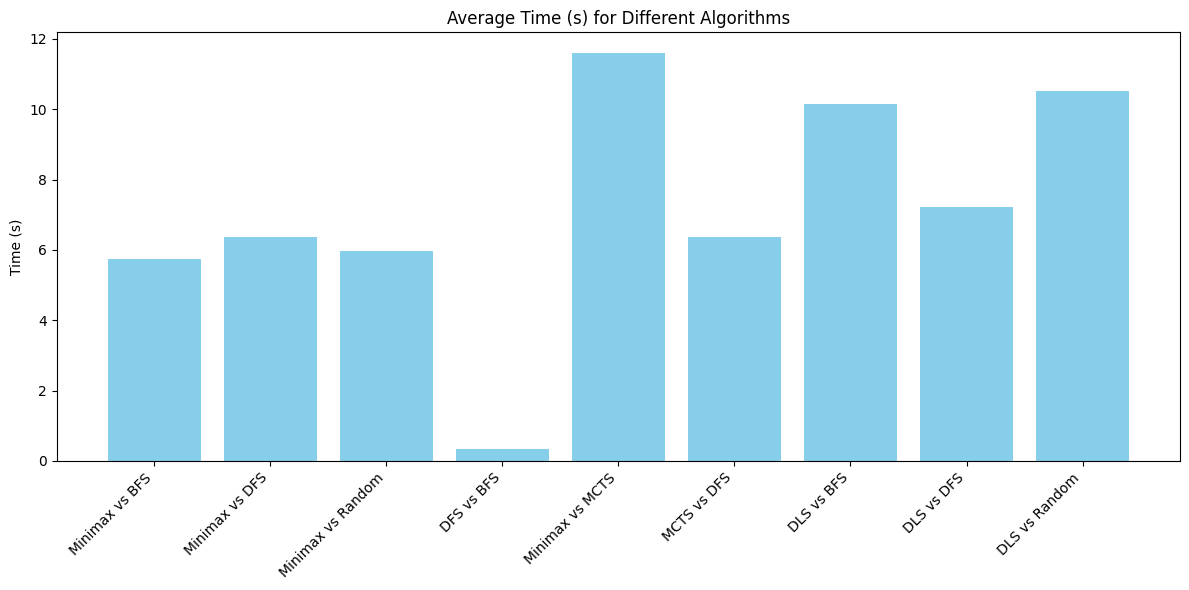

In [21]:
# Plot for Average Time (s)
plt.figure(figsize=(12, 6))
plt.bar(df["Algorithm"], df["Average Time (s)"], color='skyblue')
plt.xticks(rotation=45, ha="right")
plt.title("Average Time (s) for Different Algorithms")
plt.ylabel("Time (s)")
plt.tight_layout()
plt.show()
plt.savefig('average_time.png', dpi=300)
plt.close()

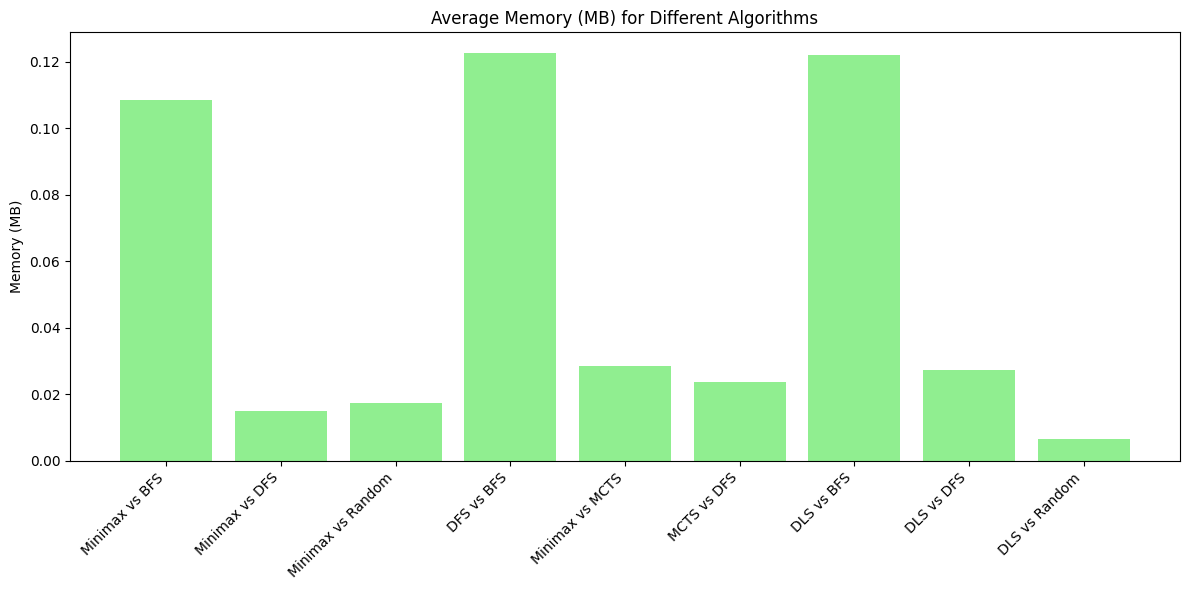

In [17]:
# Plot for Average Memory (MB)
plt.figure(figsize=(12, 6))
plt.bar(df["Algorithm"], df["Average Memory (MB)"], color='lightgreen')
plt.xticks(rotation=45, ha="right")
plt.title("Average Memory (MB) for Different Algorithms")
plt.ylabel("Memory (MB)")
plt.tight_layout()
plt.show()
plt.savefig('average_time.png', dpi=300)
plt.close()

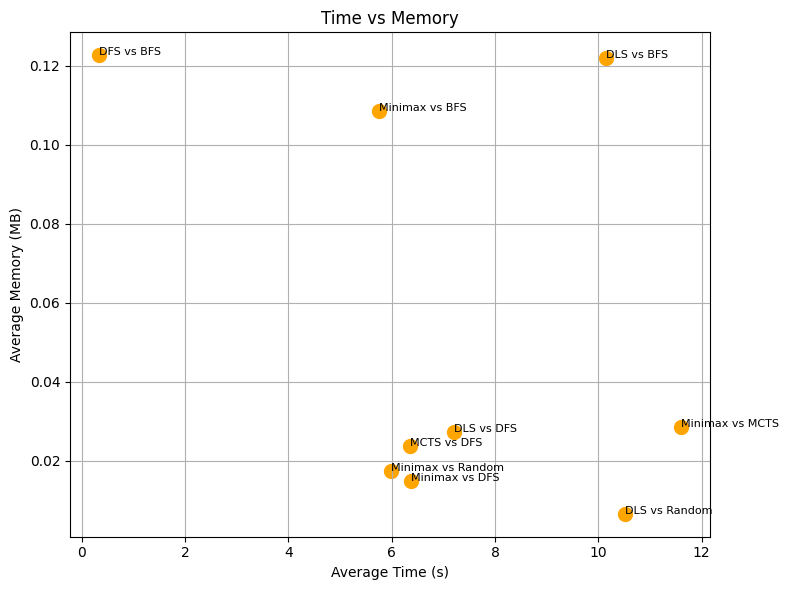

In [18]:
# Scatter plot for Time vs Memory
plt.figure(figsize=(8, 6))
plt.scatter(df["Average Time (s)"], df["Average Memory (MB)"], color='orange', s=100)
for i in range(len(df)):
    plt.text(df["Average Time (s)"][i], df["Average Memory (MB)"][i], df["Algorithm"][i], fontsize=8)
plt.title("Time vs Memory")
plt.xlabel("Average Time (s)")
plt.ylabel("Average Memory (MB)")
plt.grid(True)
plt.tight_layout()
plt.show()


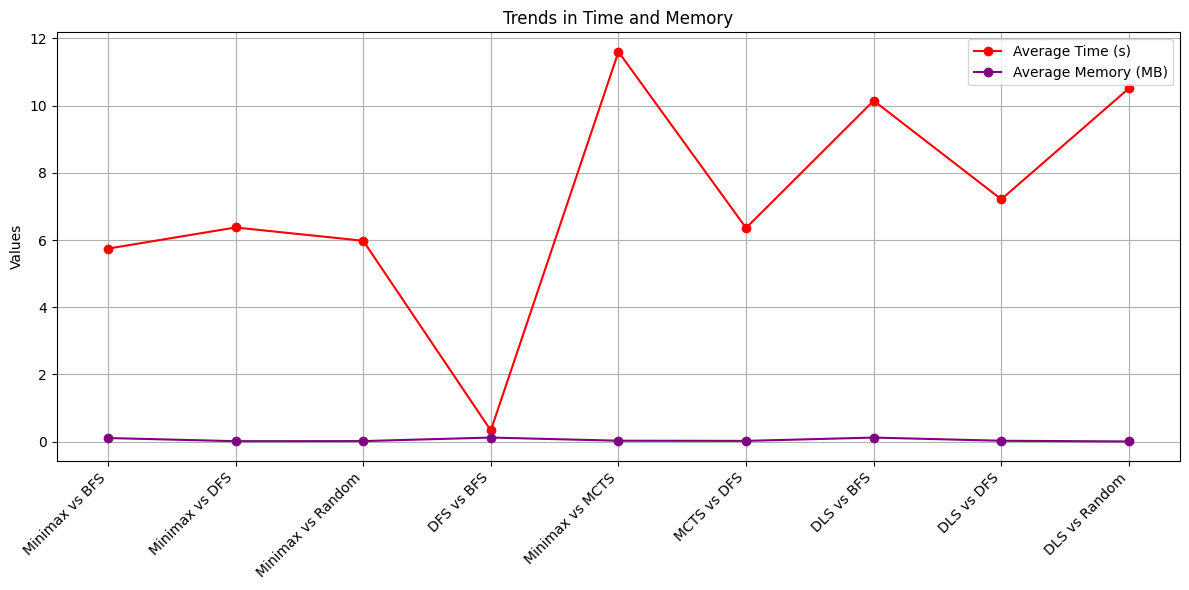

In [20]:
# Line plot for both metrics
plt.figure(figsize=(12, 6))
plt.plot(df["Algorithm"], df["Average Time (s)"], marker='o', label="Average Time (s)", color='red')
plt.plot(df["Algorithm"], df["Average Memory (MB)"], marker='o', label="Average Memory (MB)", color='purple')
plt.xticks(rotation=45, ha="right")
plt.title("Trends in Time and Memory")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
